# Load & Verify Dataset

In [3]:
import subprocess
import sys

# List of packages needed for the project
packages = [
    "tensorflow",      # For classification using Keras
    "ultralytics",     # For YOLOv8 object detection
    "opencv-python",   # For image processing
    "matplotlib",      # For visualization
    "numpy",           # For numerical operations
    "pandas",          # For data analysis (if needed)
    "torch",           # For PyTorch-based deep learning (used by YOLO)
    "torchvision",     # Additional PyTorch utilities
    "ipykernel",       # For Jupyter Notebook support
    "jupyter",         # For running Jupyter Notebooks
    "albumentations"   # For image augmentation
]

def install(package):
    """Install a package using pip."""
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

def install_all(packages):
    for package in packages:
        print(f"Installing {package}...")
        install(package)
        print(f"{package} installed successfully!\n")

if __name__ == "__main__":
    install_all(packages)
    print("All packages installed successfully!")


Installing tensorflow...
tensorflow installed successfully!

Installing ultralytics...
ultralytics installed successfully!

Installing opencv-python...
opencv-python installed successfully!

Installing matplotlib...
matplotlib installed successfully!

Installing numpy...
numpy installed successfully!

Installing pandas...
pandas installed successfully!

Installing torch...
torch installed successfully!

Installing torchvision...
torchvision installed successfully!

Installing ipykernel...
ipykernel installed successfully!

Installing jupyter...
jupyter installed successfully!

Installing albumentations...
albumentations installed successfully!

All packages installed successfully!


In [1]:
import albumentations as A
print("✅ Albumentations installed successfully!")


✅ Albumentations installed successfully!


In [2]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import albumentations as A
import numpy as np
from albumentations.pytorch import ToTensorV2
import shutil

# %% [Define Dataset Paths and Class Names]
train_images_dir = "../dataset/train/images"
train_labels_dir = "../dataset/train/labels"
valid_images_dir = "../dataset/valid/images"
valid_labels_dir = "../dataset/valid/labels"
test_images_dir = "../dataset/test/images"       # Optional
test_labels_dir = "../dataset/test/labels"         # Optional

print("✅ Dataset paths defined successfully!")

# Define your five classes
class_names = ["large_debris", "medium_debris", "rocket", "satellite", "small_debris"]


✅ Dataset paths defined successfully!


# Count the Number of Images in Each Split

In [3]:
def count_files(directory):
    return len([
        file for file in os.listdir(directory)
        if file.lower().endswith((".jpg", ".jpeg", ".png"))
    ])

# Count images in train, valid, test sets
train_count = count_files(train_images_dir)
valid_count = count_files(valid_images_dir)
test_count = count_files(test_images_dir)

print(f"🟢 Train Images: {train_count}")
print(f"🔵 Validation Images: {valid_count}")
print(f"🟠 Test Images: {test_count}")

🟢 Train Images: 15111
🔵 Validation Images: 1287
🟠 Test Images: 640


# Check Class Distribution

           Class  Count
0   small_debris    762
1  medium_debris    441
2   large_debris  76818
3      satellite  13704
4         rocket    170


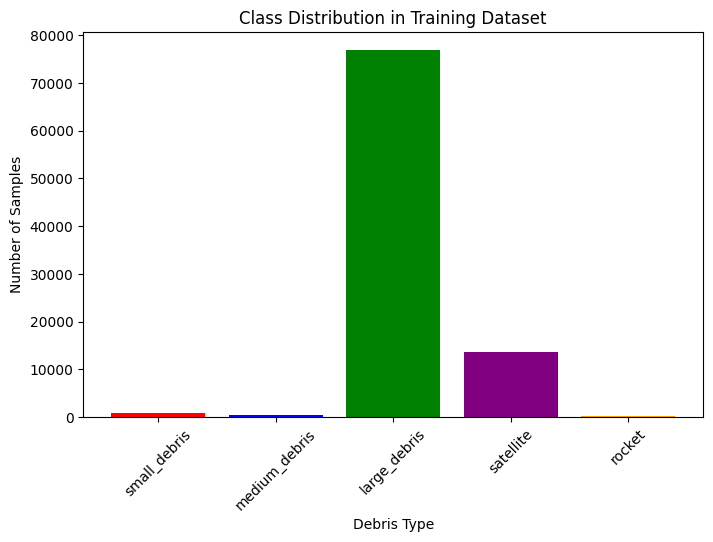

In [9]:
# Count occurrences of each class in train labels
class_counts = Counter()

for label_file in os.listdir(train_labels_dir):
    label_path = os.path.join(train_labels_dir, label_file)
    with open(label_path, "r") as f:
        for line in f.readlines():
            class_id = int(line.split()[0])  # Extract class_id
            class_counts[class_id] += 1

# Convert counts to DataFrame for better visualization
df = pd.DataFrame({
    "Class": [class_names[i] for i in class_counts.keys()],
    "Count": class_counts.values()
})
print(df)

# Plot Class Distribution
plt.figure(figsize=(8, 5))
plt.bar(df["Class"], df["Count"], color=['red', 'blue', 'green', 'purple', 'orange'])
plt.xlabel("Debris Type")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Dataset")
plt.xticks(rotation=45)
plt.show()


# Visualize Images with Annotations

Sample image: D:\Canada\Subjects\Semester -1\AIDI 1003_01_CAPSTONE TERM 1\Cosmic_Navigators_Final\dataset\train\images\-10_png_jpg.rf.6417436802ce1f127ce36c9037782b98.jpg
Sample label file: D:\Canada\Subjects\Semester -1\AIDI 1003_01_CAPSTONE TERM 1\Cosmic_Navigators_Final\dataset\train\labels\-10_png_jpg.rf.6417436802ce1f127ce36c9037782b98.txt
Skipping malformed line: ['4', '0.890625', '0.17343750000000008', '0.7328125', '0.17343750000000008', '0.7328125', '0.2906250000000001', '0.890625', '0.2906250000000001']
Skipping malformed line: ['4', '0.884375', '0.6953125000000001', '0.69375', '0.6953125', '0.6937500000000001', '0.8515625', '0.884375', '0.8515625']
Skipping malformed line: ['4', '0.2156250000000001', '0.6140625', '0.04375000000000008', '0.6140625', '0.04375000000000009', '0.8125', '0.2156250000000001', '0.8125']
Skipping malformed line: ['4', '0.4984375000000002', '0.928125', '0.4109375000000002', '0.928125', '0.4109375000000002', '1', '0.4984375000000002', '1']
Skipping malf

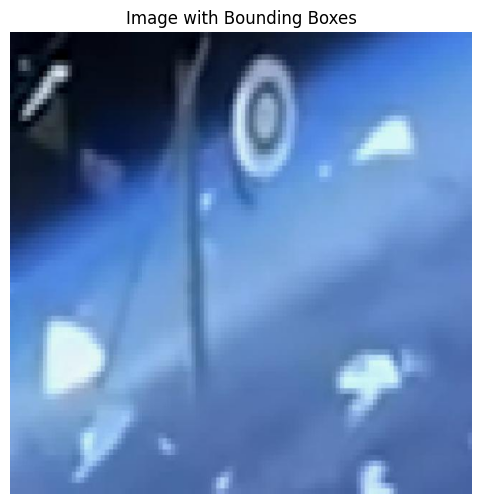

In [17]:
import os
import cv2
import matplotlib.pyplot as plt

# Define your class names (must match your model's training configuration)
class_names = ["large_debris", "medium_debris", "rocket", "satellite", "small_debris"]

def plot_image_with_boxes(image_path, label_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Unable to load image:", image_path)
        return

    # Convert image to RGB for display in matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape

    # Open and read the label file
    if not os.path.exists(label_path):
        print("Label file does not exist:", label_path)
        return

    with open(label_path, "r") as f:
        lines = f.readlines()
    
    if not lines:
        print("No labels found in:", label_path)
    
    # Process each line in the label file
    for line in lines:
        data = line.strip().split()
        if len(data) != 5:
            print("Skipping malformed line:", data)
            continue
        try:
            class_id, x, y, w, h = map(float, data)
        except ValueError as e:
            print("Error converting line to float:", data, "->", e)
            continue
        
        class_id = int(class_id)  # Ensure integer for indexing

        # Convert normalized YOLO coordinates to pixel coordinates
        x_pixel = int(x * width)
        y_pixel = int(y * height)
        w_pixel = int(w * width)
        h_pixel = int(h * height)

        # Draw bounding box on the image
        cv2.rectangle(img,
                      (x_pixel - w_pixel // 2, y_pixel - h_pixel // 2),
                      (x_pixel + w_pixel // 2, y_pixel + h_pixel // 2),
                      (0, 255, 0), 2)
        # Draw the label text (if class_id is valid)
        label_text = class_names[class_id] if class_id < len(class_names) else "unknown"
        cv2.putText(img, label_text, (x_pixel, y_pixel - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the image with bounding boxes using Matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Image with Bounding Boxes")
    plt.show()

# Update these paths to match your actual dataset structure
train_images_dir = r"D:\Canada\Subjects\Semester -1\AIDI 1003_01_CAPSTONE TERM 1\Cosmic_Navigators_Final\dataset\train\images"
train_labels_dir = r"D:\Canada\Subjects\Semester -1\AIDI 1003_01_CAPSTONE TERM 1\Cosmic_Navigators_Final\dataset\train\labels"

# Pick a sample image from your train images folder
sample_image_file = os.listdir(train_images_dir)[0]
sample_image_path = os.path.join(train_images_dir, sample_image_file)
sample_label_path = os.path.join(
    train_labels_dir,
    sample_image_file.replace(".jpg", ".txt").replace(".png", ".txt")
)

print("Sample image:", sample_image_path)
print("Sample label file:", sample_label_path)
plot_image_with_boxes(sample_image_path, sample_label_path)


In [6]:
# Data Preprocessing
!pip install albumentations opencv-python matplotlib numpy





In [7]:
!pip install --upgrade jupyterlab notebook ipykernel

In [8]:
import shutil
import albumentations as A
import numpy as np
from albumentations.pytorch import ToTensorV2
# Define your final image size for training (e.g., 640x640)
# We'll do the resizing inside Albumentations, not with cv2.resize manually.
final_img_size = 640

# Define the Albumentations pipeline with bbox_params for YOLO
augmentation_pipeline = A.Compose(
    [
        A.Resize(width=final_img_size, height=final_img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Rotate(limit=10, p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),
        # Remove ToTensorV2 if you only want to save images in .jpg
        # ToTensorV2()
    ],
    bbox_params=A.BboxParams(
        format='yolo',        # We are using YOLO format
        label_fields=['class_labels']  # The key under which labels are passed
    )
)

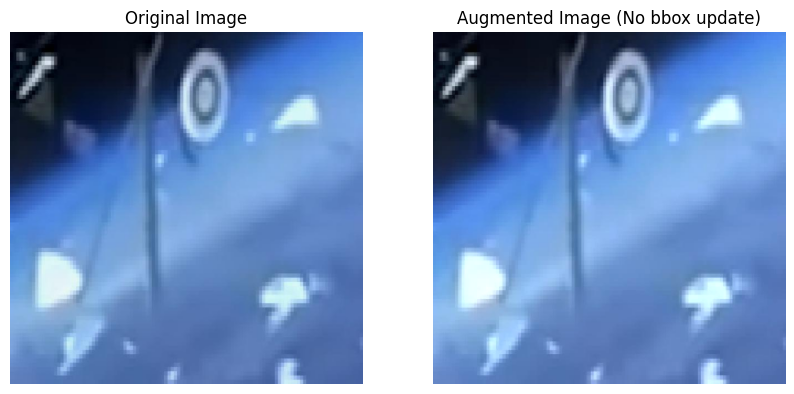

In [9]:

simple_augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=10, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    ToTensorV2()
])

def simple_apply_augmentation(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 320))  # Resize for visualization
    augmented = simple_augmentation_pipeline(image=image)
    return augmented['image'].numpy().transpose(1, 2, 0)

sample_augmented_image = simple_apply_augmentation(sample_image_path)
original_image = cv2.imread(sample_image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_image)
ax[0].set_title("Original Image")
ax[0].axis("off")
ax[1].imshow(sample_augmented_image)
ax[1].set_title("Augmented Image (No bbox update)")
ax[1].axis("off")
plt.show()


# Apply Augmentation to Entire Dataset

In [10]:
# %% [markdown]
# # Define Full Augmentation Pipeline for Detection with Bounding Box Updates
# In this pipeline, bounding boxes (in YOLO format) are updated along with image augmentations.

# %%
final_img_size = 640  # Desired final image size
augmentation_pipeline = A.Compose(
    [
        A.Resize(width=final_img_size, height=final_img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Rotate(limit=10, p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), p=0.3)
    ],
    bbox_params=A.BboxParams(
        format='yolo',        # YOLO format: [x_center, y_center, width, height] normalized
        label_fields=['class_labels']
    )
)

def load_yolo_bboxes(label_file):
    """
    Load YOLO bounding boxes from a .txt label file.
    Returns: (bboxes, class_labels)
    where bboxes is a list of [x, y, w, h] and class_labels is a list of class IDs.
    """
    bboxes = []
    class_labels = []
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                cls_id = int(parts[0])
                x, y, w, h = map(float, parts[1:])
                bboxes.append([x, y, w, h])
                class_labels.append(cls_id)
    return bboxes, class_labels

def save_yolo_bboxes(label_file, bboxes, class_labels):
    """
    Save YOLO bounding boxes to a .txt label file.
    """
    with open(label_file, 'w') as f:
        for bbox, cid in zip(bboxes, class_labels):
            x, y, w, h = bbox
            f.write(f"{cid} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

def augment_image_and_boxes(image_path, label_path, save_image_path, save_label_path):
    """
    Applies Albumentations transforms to both the image and its YOLO bounding boxes.
    Saves the resulting image and updated bounding box labels.
    """
    # 1. Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 2. Load bounding boxes from label file
    bboxes, class_labels = load_yolo_bboxes(label_path)

    # 3. Apply the augmentation pipeline
    transformed = augmentation_pipeline(
        image=image,
        bboxes=bboxes,
        class_labels=class_labels
    )

    # 4. Extract the transformed image, bboxes, and labels
    aug_image = transformed['image']
    aug_bboxes = transformed['bboxes']
    aug_class_labels = transformed['class_labels']

    # 5. Convert the augmented image back to BGR for saving
    aug_image_bgr = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_image_path, aug_image_bgr)

    # 6. Save the new YOLO bounding boxes
    save_yolo_bboxes(save_label_path, aug_bboxes, aug_class_labels)



In [11]:
# Create directories for augmented dataset
augmented_train_images_dir = "../dataset/train_augmented/images"
augmented_train_labels_dir = "../dataset/train_augmented/labels"
augmented_valid_images_dir = "../dataset/valid_augmented/images"
augmented_valid_labels_dir = "../dataset/valid_augmented/labels"

os.makedirs(augmented_train_images_dir, exist_ok=True)
os.makedirs(augmented_train_labels_dir, exist_ok=True)
os.makedirs(augmented_valid_images_dir, exist_ok=True)
os.makedirs(augmented_valid_labels_dir, exist_ok=True)

# %% [markdown]
# # Apply Augmentation to Entire Dataset

# %%
# Process the Training Dataset
for image_file in os.listdir(train_images_dir):
    if image_file.lower().endswith((".jpg", ".jpeg", ".png")):
        image_path = os.path.join(train_images_dir, image_file)
        label_path = os.path.join(train_labels_dir, image_file.replace(".jpg", ".txt").replace(".png", ".txt"))
        
        # Construct output file names
        aug_image_filename = f"aug_{image_file}"
        aug_label_filename = f"aug_{image_file.replace('.jpg', '.txt').replace('.png', '.txt')}"
        
        save_image_path = os.path.join(augmented_train_images_dir, aug_image_filename)
        save_label_path = os.path.join(augmented_train_labels_dir, aug_label_filename)
        
        # Augment and save
        augment_image_and_boxes(image_path, label_path, save_image_path, save_label_path)

# Process the Validation Dataset
for image_file in os.listdir(valid_images_dir):
    if image_file.lower().endswith((".jpg", ".jpeg", ".png")):
        image_path = os.path.join(valid_images_dir, image_file)
        label_path = os.path.join(valid_labels_dir, image_file.replace(".jpg", ".txt").replace(".png", ".txt"))
        
        # Construct output file names
        aug_image_filename = f"aug_{image_file}"
        aug_label_filename = f"aug_{image_file.replace('.jpg', '.txt').replace('.png', '.txt')}"
        
        save_image_path = os.path.join(augmented_valid_images_dir, aug_image_filename)
        save_label_path = os.path.join(augmented_valid_labels_dir, aug_label_filename)
        
        # Augment and save
        augment_image_and_boxes(image_path, label_path, save_image_path, save_label_path)

print("✅ Dataset Augmentation Completed! New images & label files saved with updated bounding boxes.")

✅ Dataset Augmentation Completed! New images & label files saved with updated bounding boxes.
